In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [22]:
folder = 'TDE'
is_tde = True
snap = '210'
m = 5
beta = 2
path = f'{folder}/{snap}'
G = 1
Mbh = 10**m
Rt = Mbh**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = 2 * Rt * Mbh**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2


In [23]:
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
 
    return np.array(z)

def to_cylindric(x,y):
    radius = np.sqrt(x**2+y**2)
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    # theta_coord go from -pi to pi with negative values in the 3rd and 4th quadrant. You want to switch 
    theta_broadcasted = -theta_coord
    return theta_broadcasted, radius

def from_cylindric(theta, r):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a):
    # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
    theta = -theta
    p = 2 * a
    radius = p / (1 + np.cos(theta))
    return radius

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    if np.abs(theta_chosen - np.pi/2) < 0.1: # if theta is close to pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data < 0) # only the lower part
    elif np.abs(theta_chosen + np.pi/2) < 0.1: # if theta is close to -pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data > 0) # only the upper part
    else:
        # we need the - in front of theta to be consistent with the function to_cylindric, where we change the orientation of the angle
        m = np.tan(-theta_chosen)
        condition_coord = np.abs(y_data - m * x_data) < dim_data
        if np.logical_and(theta_chosen > 0, theta_chosen != np.pi): # if theta is in the third or fourth quadrant
            condition_coord = np.logical_and(condition_coord, y_data < 0)
        elif theta_chosen == 0:
            condition_coord = np.logical_and(condition_coord, x_data >= 0)
        elif np.abs(theta_chosen) == np.pi:
            condition_coord = np.logical_and(condition_coord, x_data < 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data > 0)
    return condition_coord

# def avg_consecutive_triplets(array, i, choose):
#     if choose == 'before':
#         triplet = array[i-3:i+1]
#     else:
#         triplet = array[i:i+3+1]
#     avg = sum(triplet) / 3

#     if choose == 'before':
#         return avg, i-3
#     else: 
#         return avg, i+3

def find_width(x_mid, y_mid, dim_mid, den_mid, theta_cm):
    threshold = 1/3
    # find the normal plane 
    condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_cm)
    x_plane = x_mid[condition_coord]
    y_plane = y_mid[condition_coord]
    r_plane = np.sqrt(x_plane**2 + y_plane**2)
    den_plane = den_mid[condition_coord]
    # sort 
    r_plane = list(r_plane)
    x_plane_sorted = sort_list(x_plane, r_plane)
    y_plane_sorted = sort_list(y_plane, r_plane)
    den_plane_sorted = sort_list(den_plane, r_plane)

    # find the cm of the plane
    idx_cm = np.argmax(den_plane_sorted)    
    x_cm = x_plane_sorted[idx_cm]
    y_cm = y_plane_sorted[idx_cm]
    den_cm = den_plane_sorted[idx_cm]
    
    # walk before and after the cm till you find a density 3 times smaller
    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step > 0:
        idx_step -= 1
        den_tube = den_plane_sorted[idx_step]
    idx_before = idx_step+1
    x_low = x_plane_sorted[idx_before]
    y_low = y_plane_sorted[idx_before]
    den_low = den_tube

    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step < len(den_plane_sorted) - 1:
        idx_step += 1
        den_tube  = den_plane_sorted[idx_step]
    idx_after = idx_step-1
    x_high = x_plane_sorted[idx_after]
    y_high = y_plane_sorted[idx_after]
    den_high = den_tube
    
    return x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high

def find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    cm = np.zeros((3,len(theta_arr)))
    upper_tube = np.zeros((3,len(theta_arr)))
    lower_tube = np.zeros((3,len(theta_arr)))
    for i,theta in enumerate(theta_arr):
        x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high = find_width(x_mid, y_mid, dim_mid, den_mid, theta)
        cm[0][i], cm[1][i], cm[2][i] = x_cm, y_cm, den_cm
        lower_tube[0][i], lower_tube[1][i], lower_tube[2][i] = x_low, y_low, den_low
        upper_tube[0][i], upper_tube[1][i], upper_tube[2][i] = x_high, y_high, den_high
    
    return cm, upper_tube, lower_tube

def find_streams(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    # first run to find the maxima (1 for every theta in theta_arr!). NB: the could be on different streams
    cm, upper_tube, lower_tube = find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr) 
    second_cm = []
    for i in range(len(cm[0])): #cm has 3 rows and len(theta_arr) columns
        #find again the normal plane
        condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_arr[i])
        x_norm = x_mid[condition_coord]
        y_norm = y_mid[condition_coord]
        r_norm = np.sqrt(x_norm**2 + y_norm**2)

        den_norm = den_mid[condition_coord]
        x_upper = upper_tube[0][i]
        y_upper = upper_tube[1][i]
        r_upper = np.sqrt(x_upper**2 + y_upper**2)
        x_lower = lower_tube[0][i]
        y_lower = lower_tube[1][i]
        r_lower = np.sqrt(x_lower**2 + y_lower**2)

        cond_rlow = np.logical_and(r_norm > R0, r_norm < r_lower)
        x_second = x_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        y_second = y_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        den_second = den_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        idx_cm2 = np.argmax(den_second)
        if den_second[idx_cm2] > cm[2][i]/3:
            second_cm.append([x_second[idx_cm2], y_second[idx_cm2], den_second[idx_cm2]])
    # broadcast as cm
    second_cm = np.transpose(second_cm)
    return cm, second_cm

def parameters_orbit(p, a):
    En = G * Mbh * (p**2 * (a-Rs) - a**2 * (p-Rs)) / ((a**2-p**2) * (p-Rs) * (a-Rs))
    L = np.sqrt(2 * a**2 * (En + G*Mbh/(a-Rs)))
    return En, L

def solvr(x, theta):
    _, L = parameters_orbit(Rp, apo)
    u,y = x
    res =  np.array([y, (-u + G * Mbh / ((1 - Rs*u) * L)**2)])
    return res

def Witta_orbit(theta_data):
    u,y = odeint(solvr, [0, 0], theta_data).T 
    r = 1/u
    return r

Load data

In [24]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Mass, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

R = np.sqrt(X**2 + Y**2 + Z**2)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
dim_cell = Vol**(1/3) # according to Elad
theta, Rcyl = to_cylindric(X,Y)
time, tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m=m, choose = 'tfb')

days after disruption: 3.456952163743516, t_fall: 12.649110640673518


Text(0.5, 1.0, '$\\theta$ = -0.79')

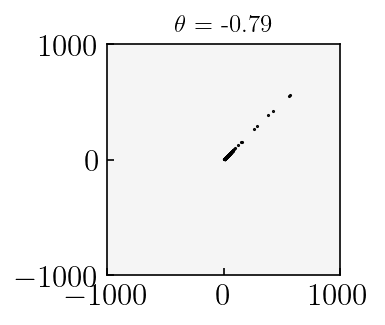

In [25]:
# check if anglese are correct
check = -np.pi/4
plt.figure(figsize=(2,2))
plt.plot(X[np.abs(theta - check) < 0.01], Y[np.abs(theta - check) < 0.01], 'o', markersize = 0.5, c='k')
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.title(r'$\theta$ = '+ f'{np.round(check,2)}')

Analytic curves

In [26]:
theta_lim = 3/4*np.pi
theta_arr = np.arange(-theta_lim, theta_lim, 0.02) 

# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
theta_arr_kep = np.arange(0, 2*np.pi, 0.01)
r_orbit = keplerian_orbit(theta_arr_kep, a = Rp)
x_orbit, y_orbit = from_cylindric(theta_arr_kep, r_orbit) 

# Witta
theta_arr_kep = np.arange(-np.pi, np.pi, 0.01)
Witta_r = Witta_orbit(theta_arr_kep)
x_Witta_orbit, y_Witta_orbit = from_cylindric(theta_arr_kep, Witta_r) 

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_45411/3019206691.py:167: RuntimeWarning: divide by zero encountered in divide
  r = 1/u


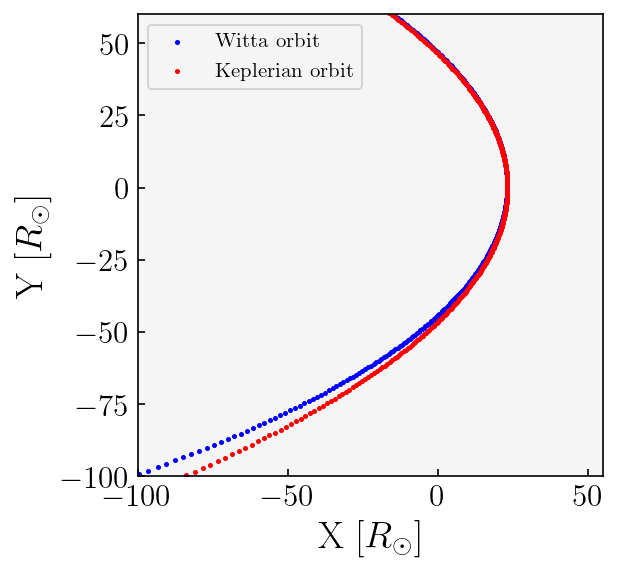

In [27]:
plt.figure(figsize=(4,4))
plt.scatter(x_Witta_orbit, y_Witta_orbit, c='b', s = 2, label='Witta orbit')
plt.scatter(x_orbit, y_orbit, c='r', s = 2, label='Keplerian orbit')
plt.xlim(-100,55)
plt.ylim(-100,60)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.legend()

Midplane 

In [28]:
# take wanted data
midplane = np.abs(Z) < dim_cell

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
dim_cross = dim_cell[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
Mass_cross   = Mass[midplane]

In [29]:
# # check if the normal plane is correct
# theta_chosen = np.pi/4
# radius_chosen = keplerian_orbit(theta_chosen, a = Rp)
# x_chosen, y_chosen = from_cylindric(theta_chosen, radius_chosen)
# condition_norm = normal_plane(X, Y, dim_cell, theta_chosen)
# X_norm = X[condition_norm]
# Y_norm = Y[condition_norm]
# Z_norm = Z[condition_norm]
# X_norm_cross = X_norm[np.abs(Z_norm) < dim_cell[condition_norm]]
# Y_norm_cross = Y_norm[np.abs(Z_norm) < dim_cell[condition_norm]]

# fig, ax = plt.subplots(figsize = (4,4))
# img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 2, cmap = 'jet', vmin = -12, vmax = -7.5)
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# ax.scatter(X_norm_cross, Y_norm_cross, s = 0.5, c = 'k')
# ax.scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
# ax.scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
# ax.set_xlim(-100,50)
# ax.set_ylim(-80,80)
# ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

In [30]:
cm, upper_tube, lower_tube  = find_width_stream(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

Text(0, 0.5, 'Y [$R_\\odot$]')

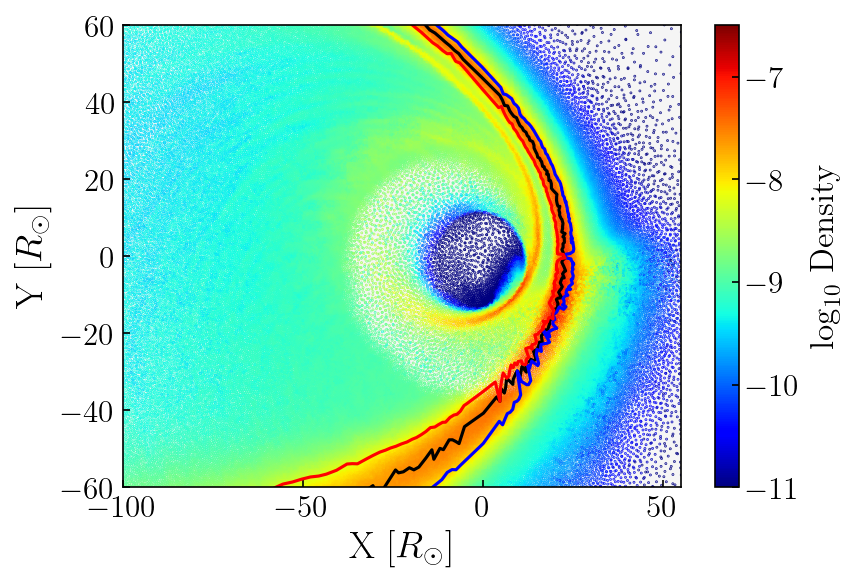

In [31]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -11, vmax = -6.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.plot(cm[0], cm[1], c = 'k')
ax.plot(upper_tube[0], upper_tube[1],  c = 'b')
ax.plot(lower_tube[0], lower_tube[1],  c = 'r')
ax.set_xlim(-100,55)
ax.set_ylim(-60,60)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

/Users/paolamartire/miniconda3/envs/shocks/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/paolamartire/miniconda3/envs/shocks/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


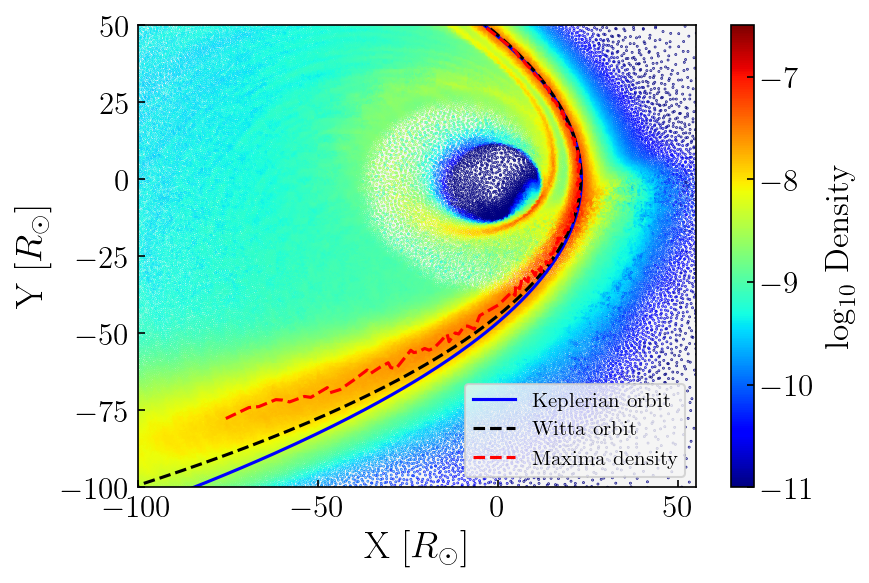

In [32]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -11, vmax = -6.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.plot(x_orbit, y_orbit, c = 'b', label = 'Keplerian orbit')
ax.plot(x_Witta_orbit, y_Witta_orbit, c = 'k', linestyle = '--', label = 'Witta orbit')
ax.plot(cm[0], cm[1], c = 'r', linestyle = '--', label = 'Maxima density')
ax.set_xlim(-100,55)
ax.set_ylim(-100,50)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
ax.legend()

Text(0, 0.5, 'Width [$R_\\odot$]')

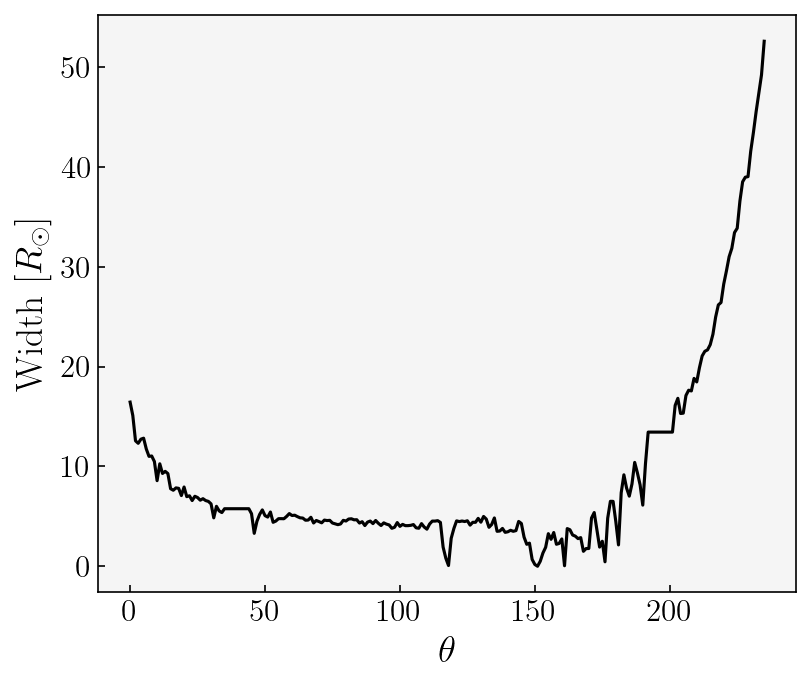

In [33]:
r_upper = np.sqrt(upper_tube[0]**2 + upper_tube[1]**2)
r_lower = np.sqrt(lower_tube[0]**2 + lower_tube[1]**2)
width = r_upper - r_lower
plt.figure(figsize=(6,5))
plt.plot(width, c = 'k')
plt.xlabel(r'$\theta$', fontsize = 18)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 18)

In [34]:
first_cm, second_cm = find_streams(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

(-60.0, 60.0)

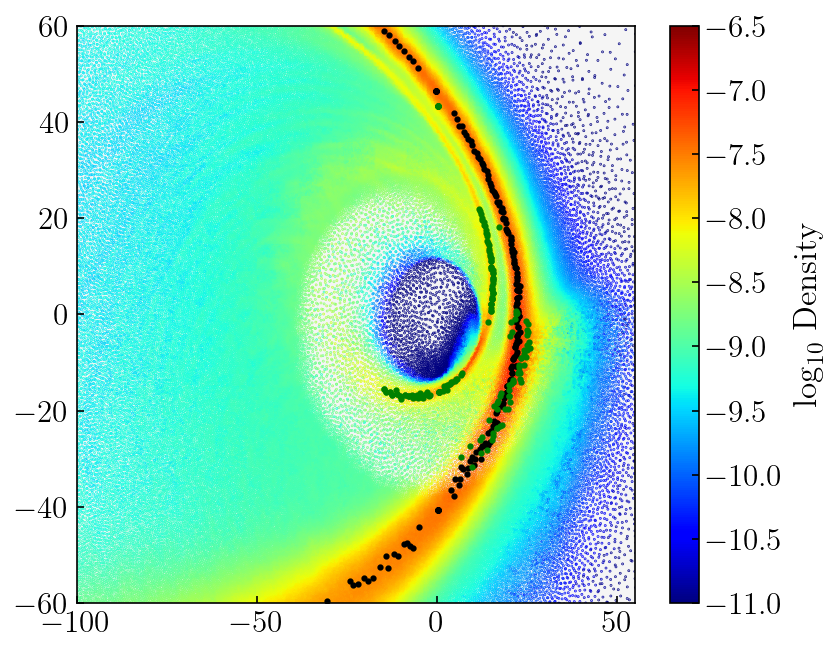

In [35]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -11, vmax = -6.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.scatter(first_cm[0], first_cm[1], s = 4, c = 'k')
ax.scatter(second_cm[0], second_cm[1], s = 4, c = 'green')
ax.set_xlim(-100,55)
ax.set_ylim(-60,60)

Stone13

In [36]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

In [39]:
z_arr = np.arange(-1, 1, .2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

(-1.0, 1.0)

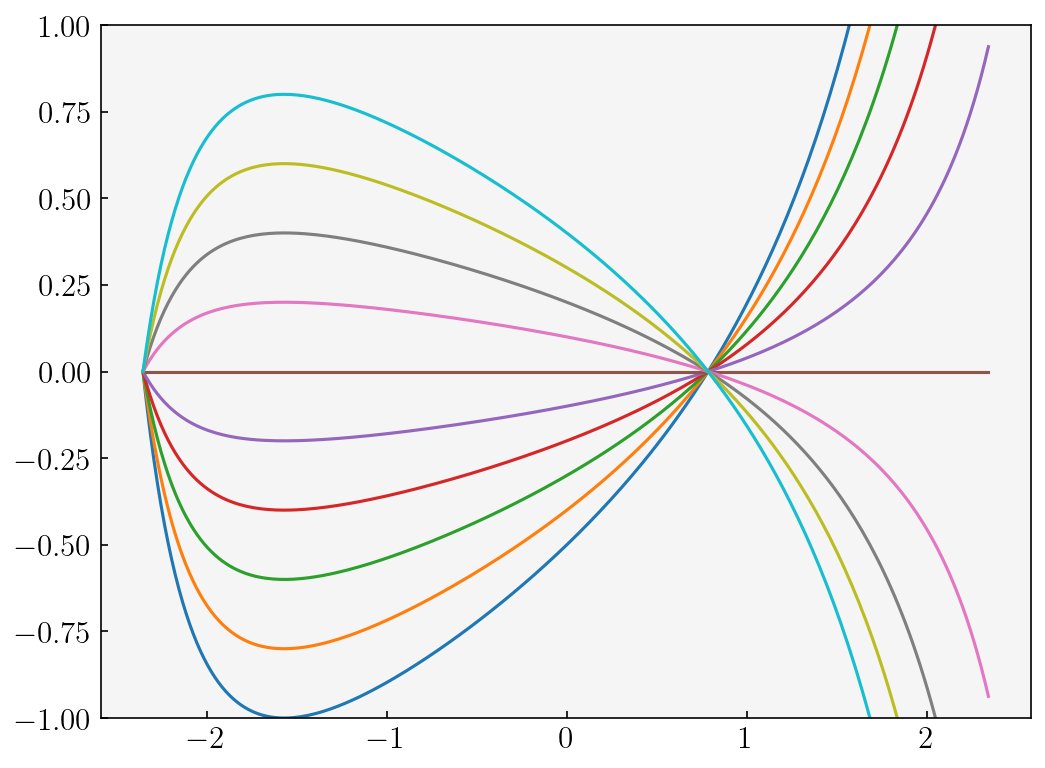

In [41]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
plt.ylim(-1,1)